In [1]:
import pandas as pd
import pylab as plt
import numpy as np

df=pd.read_csv("Harzgerode_train.csv", infer_datetime_format=True, index_col="date")
df["date"]=pd.to_datetime(df.index)
df.set_index(df["date"], inplace=True)
df.drop("date", axis=1, inplace=True)

df["timestep"]=(df.index-df.index[0]).days.to_numpy()

(7305.0, 10957.0)

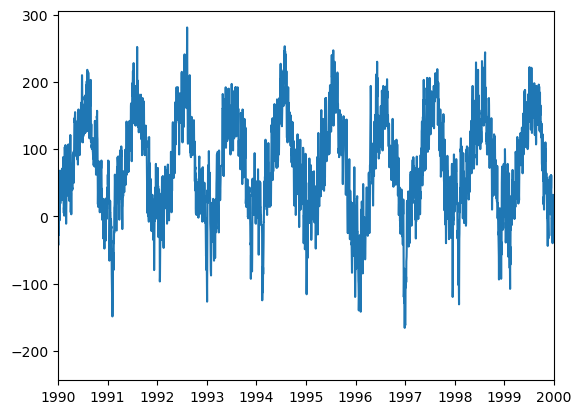

In [2]:
plt.plot(df.index, df["temp"])
plt.xlim(pd.Timestamp('1990-01-01'), pd.Timestamp('2000-01-01'))

## Estimating Trend using Polynominal Features

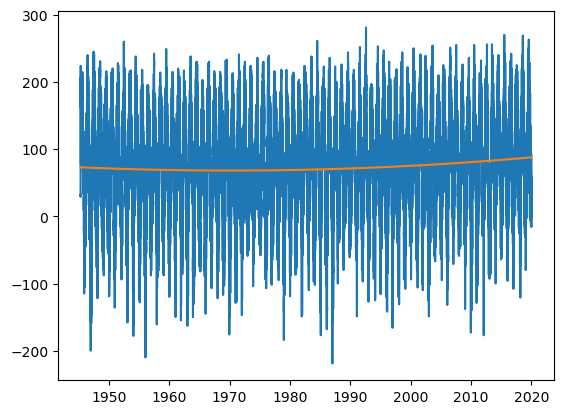

In [3]:
from sklearn.linear_model import LinearRegression
m_poly=LinearRegression()

df["t²"]=df["timestep"]**2

m_poly.fit(df[["timestep", "t²"]], df["temp"])

df["trend"]=m_poly.predict(df[["timestep", "t²"]])
plt.plot(df.index,df["temp"])
plt.plot(df.index,df["trend"]);

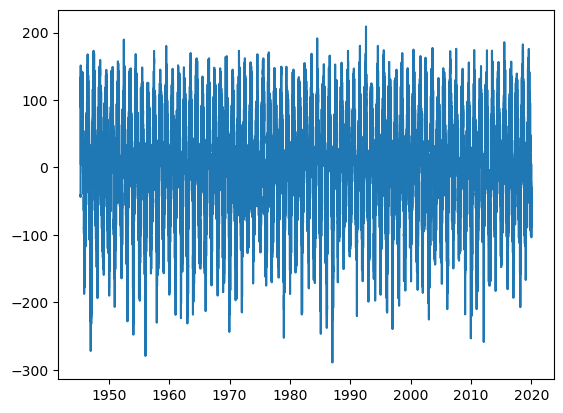

In [4]:
df["detrend"] = df["temp"]-df["trend"]
plt.plot(df.index,df["detrend"])

### Perform Frequency Analysis to get Seasonality

In [5]:
def frequency_analysis(df,feature="temp", zeropad=10000000):
    import numpy as np
    X=df.index
    DAYS=(X-X[0]).days.to_numpy()
    Y=df[feature]
    Yzp=np.r_[Y.to_numpy(), np.zeros(zeropad)]
    # Fourier Transformation
    from numpy import fft
    freq=fft.fftfreq(len(Yzp), 1)
    spec=fft.fft(Yzp)
    gz= ((np.divide(1,freq, where=np.abs(freq)>0)<365*20)  * (freq>0))
    return freq[gz],spec[gz]

In [45]:
freq_dt,spec_dt=frequency_analysis(df[["detrend"]], feature="detrend")

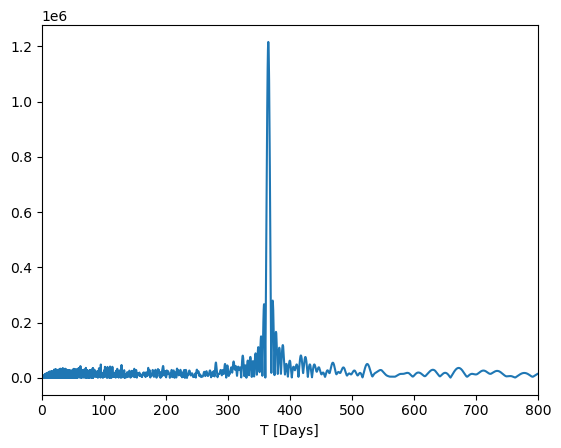

In [53]:
plt.plot(1/freq_dt, np.abs(spec_dt))
plt.xlim(0,800)
plt.xlabel("T [Days]");

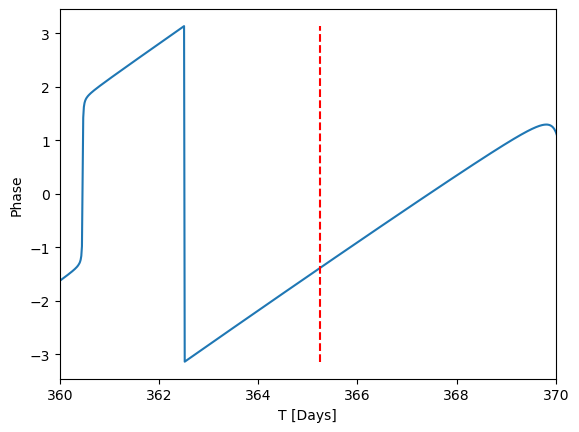

In [61]:
plt.plot(1/freq_dt, np.angle(spec_dt))
plt.xlim(360,370)
plt.ylabel("Phase")
plt.plot([mainT,mainT], [-np.pi,np.pi], "r--")
plt.xlabel("T [Days]");

In [117]:
aspec=np.abs(spec)
phase_spec=np.angle(spec)
mainT=round(1/freq[aspec==aspec.max()][0],2)
phase=round(phase_spec[aspec==aspec.max()][0],7)
print("Main Period is ", mainT ,"days, which is close to 365.25 days")
print("The phase of the main Period is ", phase, phase*180/np.pi )

Main Period is  365.25 days, which is close to 365.25 days
The phase of the main Period is  -1.3801505 -79.07679874287034


In [118]:
freq_cos=1/mainT
df["cosi"]=df["timestep"].apply(lambda t: np.cos(2*np.pi*freq_cos*t + phase))

In [9]:
m_season=LinearRegression()
m_season.fit(df[["cosi"]], df["detrend"])
df["season"]=m_season.predict(df[["cosi"]])


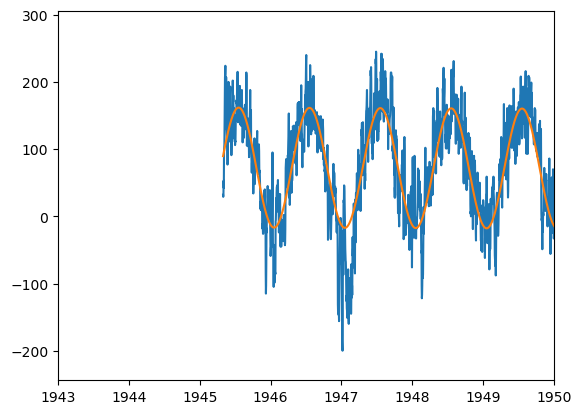

In [10]:
#Baseline model
plt.plot(df.index,df["temp"])
plt.plot(df.index, df["season"]+df["trend"])

    
    
plt.xlim(pd.Timestamp('1943-01-01'), pd.Timestamp('1950-01-01'));

(3652.0, 18993.0)

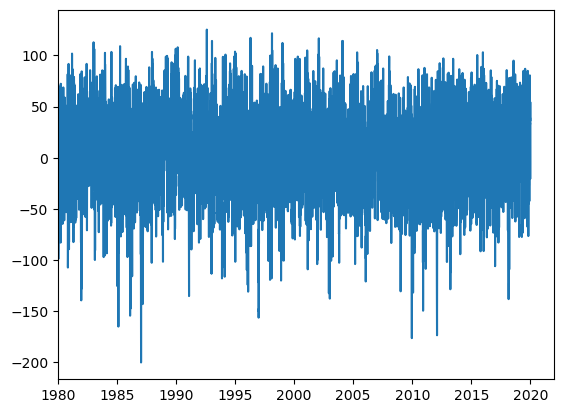

In [11]:
df["remainder"]=df["detrend"]-df["season"]

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(df.index, df["remainder"])
ax1.set_xlim(pd.Timestamp('1980-01-01'), pd.Timestamp('2022-01-01'))

In [37]:
frq_rem, spec_rem=frequency_analysis(df[["remainder"]], "remainder")

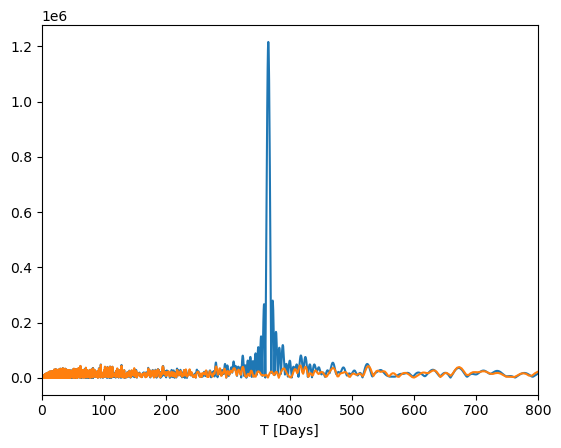

In [51]:

plt.plot(1/freq_dt, np.abs(spec_dt))
plt.plot(1/frq_rem, np.abs(spec_rem))
plt.xlim(0,800)
plt.xlabel("T [Days]");

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima


In [13]:
def adfuller_test(series):
    result=adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating data is non-stationary")

        
adfuller_test(df['remainder'])

ADF Test Statistic : -46.13946696963314
p-value : 0.0
#Lags Used : 4
Number of Observations Used : 27268
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [27]:
auto_arima_model = auto_arima(df['remainder'], 
                              start_p=0, start_q=0, 
                              max_p=10, max_q=10, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=276469.804, Time=0.96 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=248463.793, Time=2.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=257577.785, Time=7.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=276467.804, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=247855.793, Time=2.64 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=247654.423, Time=3.75 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=247652.542, Time=4.58 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=247643.759, Time=5.19 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=247645.152, Time=6.67 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=247642.259, Time=84.00 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=247657.938, Time=10.79 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=247647.412, Time=13.21 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=247637.062, Time=81.59 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=247646.862, Time=34.13 sec


In [53]:
auto_arima_model

ARIMA(order=(5, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [14]:
model_rem = ARIMA(df['remainder'], order=(5,0,2)).fit()

/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [78]:
df_rem=df[['remainder']]

In [66]:
df_rem=df_rem["remainder"].append(model_rem.forecast())

/tmp/ipykernel_21673/2876715700.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem["remainder"].append(model_rem.forecast())


1945-05-01   -57.549344
1945-05-02   -62.052347
1945-05-03   -61.549903
1945-05-04   -41.041569
1945-05-05   -53.526903
                ...    
2019-12-28   -20.766822
2019-12-29    -6.205590
2019-12-30    54.331007
2019-12-31    36.842811
2020-01-01    21.935637
Length: 27274, dtype: float64

In [89]:
for i in range(31): 
    print(i)
    df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
    model_rem =  ARIMA(df_rem[['remainder']], order=(5,0,2)).fit()

0


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

1


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

2


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

3


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

4


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

5


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

6


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

7


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

8


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

9


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

10


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

11


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

12


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

13


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

14


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

15


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

16


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

17


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

18


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

19


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

20


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

21


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

22


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

23


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

24


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

25


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

26


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

27


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

28


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

29


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

30


/tmp/ipykernel_21673/11734931.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rem = pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/pyth

(18245.0, 18307.0)

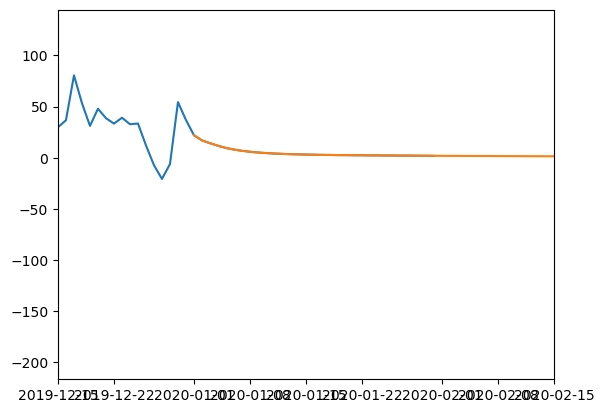

In [102]:
plt.plot(df_rem.index,df_rem["remainder"])
plt.plot(model_rem.predict(start='2020-01-01', end='2020-02-15').index, model_rem.predict(start='2020-01-01', end='2020-02-15'))
plt.xlim(pd.Timestamp('2019-12-15'), pd.Timestamp('2020-02-15'))

In [88]:
pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])

/tmp/ipykernel_21673/1746661203.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd.DataFrame(df_rem["remainder"].append(model_rem.forecast()), columns=["remainder"])


,remainder
1945-05-01,-57.549344
1945-05-02,-62.052347
1945-05-03,-61.549903
1945-05-04,-41.041569
1945-05-05,-53.526903
...,...
2019-12-28,-20.766822
2019-12-29,-6.205590
2019-12-30,54.331007
2019-12-31,36.842811


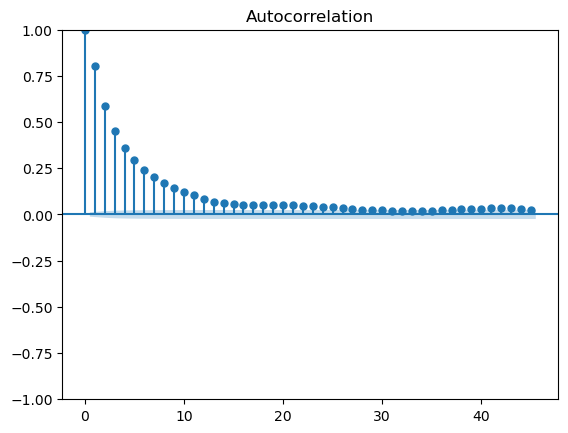

In [82]:
plot_acf(df["remainder"]);

/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


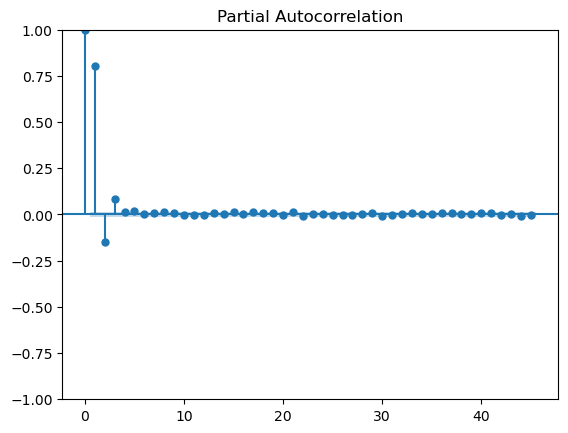

In [83]:
plot_pacf(df["remainder"]);

(17532.0, 17897.0)

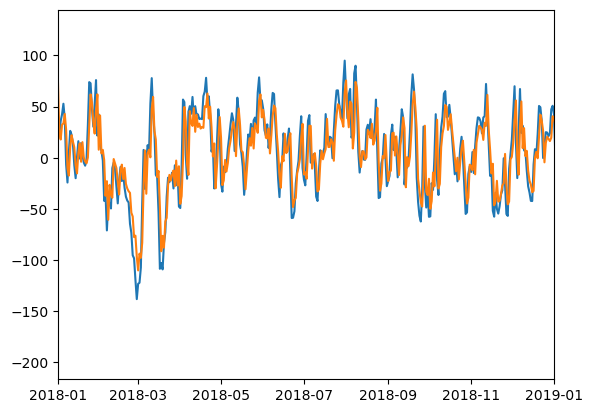

In [49]:
plt.plot(df.index,df["remainder"])
plt.plot(df.index,model_rem.predict())

plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2019-01-01'))

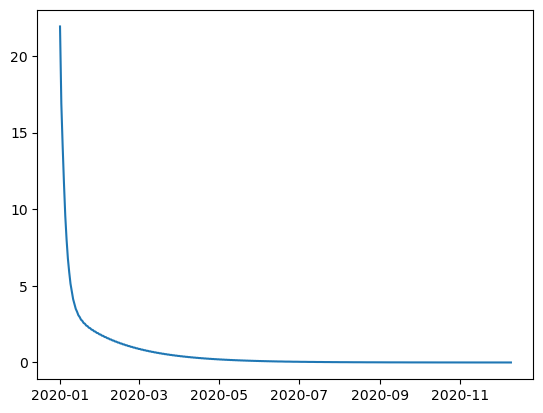

In [24]:
plt.plot(model_rem.predict(start='2020-01-01', end='2020-12-10'))

In [17]:
len(df.index)

27273

In [18]:
df.index> pd.Timestamp("2018-01-01")

array([False, False, False, ...,  True,  True,  True])

In [20]:
df_small=df[df.index> pd.Timestamp("2018-01-01")]

In [21]:
df_small["reminder"]

,temp,timestep,t²,trend,detrend,cosi,season,remainder
date,,,,,,,,
2018-01-02,23.0,26544,704583936,86.166544,-63.166544,-0.958259,-85.723955,22.557411
2018-01-03,36.0,26545,704637025,86.168615,-50.168615,-0.963035,-86.149988,35.981372
2018-01-04,42.0,26546,704690116,86.170687,-44.170687,-0.967526,-86.550600,42.379914
2018-01-05,52.0,26547,704743209,86.172758,-34.172758,-0.971731,-86.925675,52.752917
2018-01-06,37.0,26548,704796304,86.174830,-49.174830,-0.975649,-87.275100,38.100270
...,...,...,...,...,...,...,...,...
2019-12-27,-2.0,27268,743543824,87.697068,-89.697068,-0.920373,-82.344545,-7.352522
2019-12-28,-16.0,27269,743598361,87.699224,-103.699224,-0.926964,-82.932402,-20.766822
2019-12-29,-2.0,27270,743652900,87.701381,-89.701381,-0.933280,-83.495791,-6.205590


In [103]:
auto_arima_model = auto_arima(df_small[['remainder']], 
                              start_p=0, start_q=0, 
                              max_p=15, max_q=15, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7383.491, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6627.842, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6828.329, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7392.942, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6588.900, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6575.878, Time=0.23 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=6577.808, Time=0.91 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=6577.785, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6577.334, Time=0.27 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=6579.087, Time=1.81 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=6575.487, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6588.994, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=6577.442, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6577.426, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]          

In [34]:
model_rem_small = ARIMA(df_small[['remainder']], order=(30,0,2)).fit()

/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


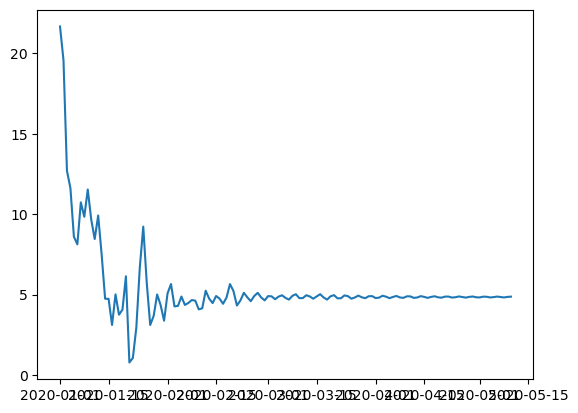

In [36]:
plt.plot(model_rem_small.predict(start='2020-01-01', end='2020-05-10'))

In [104]:
mod_rem_small_1=ARIMA(df_small[['remainder']], order=(10,0,0)).fit()

/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


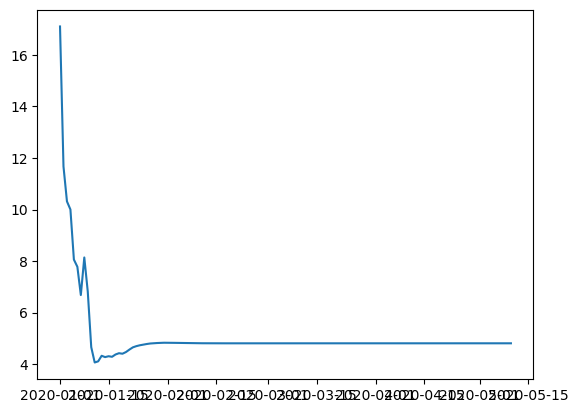

In [107]:
plt.plot(mod_rem_small_1.predict(start='2020-01-01', end='2020-05-10'))

In [108]:
!ls

climate_data_import.ipynb	     manual_detrend_deseason.ipynb
climate_test.csv		     model_remainder-Copy1.ipynb
climate_train.csv		     model_remainder.ipynb
data				     read_data.py
do_different_lp_filters.ipynb	     read_data_weatherstation.ipynb
do_filter_the_data.ipynb	     read_train.py
frequency_analysis.py		     Untitled1.ipynb
Harzgerode_test.csv		     Untitled2.ipynb
Harzgerode_train.csv		     Untitled.ipynb
manual_detrend_deseason-Copy1.ipynb


In [110]:
df_test=pd.read_csv("Harzgerode_test.csv", infer_datetime_format=True, index_col="date")
df_test["date"]=pd.to_datetime(df_test.index)
df_test.set_index(df_test["date"], inplace=True)
df_test.drop("date", axis=1, inplace=True)

df_test["timestep"]=(df_test.index-df.index[0]).days.to_numpy()

In [111]:
df_test["t²"]=df_test["timestep"]**2

In [119]:
df_test["cosi"]=df_test["timestep"].apply(lambda t: np.cos(2*np.pi*freq_cos*t + phase))

In [120]:
df_test.head()

,temp,timestep,t²,cosi
date,,,,
2020-01-01,-2.0,27273,743816529,-0.950564
2020-01-02,20.0,27274,743871076,-0.955765
2020-01-03,37.0,27275,743925625,-0.960683
2020-01-04,23.0,27276,743980176,-0.965317
2020-01-05,8.0,27277,744034729,-0.969665


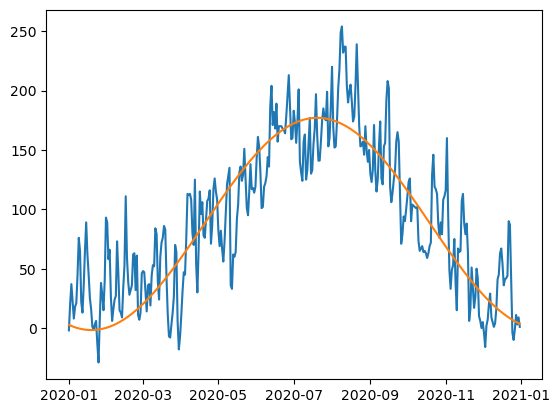

In [129]:
plt.plot(df_test.index,df_test["temp"])

plt.plot(df_test.index,m_poly.predict(df_test[["timestep", "t²"]]) + m_season.predict(df_test[["cosi"]]))


<AxesSubplot:xlabel='date'>

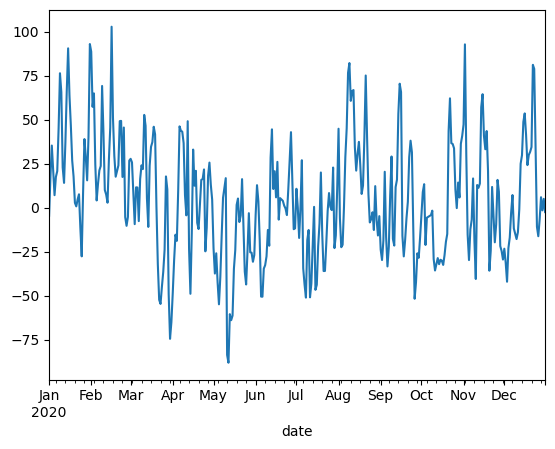

In [128]:
(df_test["temp"] -( m_poly.predict(df_test[["timestep", "t²"]]) + m_season.predict(df_test[["cosi"]]) )).plot()